## SNP calling

These are some notes on the (old) paper:

*Li, H. A statistical framework for SNP calling, mutation discovery, association mapping and population genetical parameter estimation from sequencing data. Bioinformatics, Vol. 27, no. 21, 2011, pp. 2987-2993.*

For simplicity, we assume we have a diploid individual.  We imagine that we do some sequencing experiments on a population in Hardy-Weinberg equilibrium (HWE). We are interested in a particular site in the genome, where we assume that our sequencing experiments yield either a reference allele R or an alternative allele A.  We would like to estimate the
frequency $\psi$  of the reference allele in the population. 

A given individual can have one of three genotypes: RR, RA, and AA.  Since the population is in HWE, the frequencies of these genotypes are $\psi^2$, $2\psi(1-\psi)$, and $(1-\psi)^2$.  

A sequencing experiment of depth $k$ on an individual yields $l$ reference bases $R_1,\ldots, R_{l}$  and $k-l$ alternative bases $A_{l+1}, \ldots, A_{k}$. 
Each base also has an associated error $\epsilon_j$ which is the probability that the $j^{th}$ base read is incorrect.

Let $g$ be the number of reference bases in the genotype (so $g=0,1,2$).  The
likelihood of obtaining $l$ reference bases out of $k$ tries assuming genotype $g=0$ is
$$
P(l|g=0)=\prod_{j=1}^{l}P(\mathrm{read}_j=R|\mathrm{truth}_j=A) \prod_{j=l+1}^{k}P(\mathrm{read}_j=A|\mathrm{truth}_j=A)=\prod_{j=1}^{l}\epsilon_{j}\prod_{j=l+1}^{k}(1-\epsilon_{j})
$$

In the $g=1$ case, we use the fact that
$$
P(\mathrm{truth}=A)=P(\mathrm{truth}=R)=\frac{1}{2}
$$
and
$$
P(\mathrm{read}=R|\mathrm{truth}=A)=P(\mathrm{read}=A|\mathrm{truth}=R)=\epsilon
$$
to conclude that
$$
P(\mathrm{read}=R)=P(\mathrm{read}=R|\mathrm{truth}=R)P(\mathrm{truth}=R)+P(\mathrm{read}=R|\mathrm{truth}=A)P(\mathrm{truth}=A)=\frac{1}{2}
$$
and similarly 
$$
P(\mathrm{read}=A)=\frac{1}{2}.
$$

Therefore:
$$
P(l|g=1)=\prod_{j=1}^{l}P(\mathrm{read}_j=R)\prod_{j=l+1}^{k}P(\mathrm{read}_j=A)=\frac{1}{2^k}
$$

Lastly, the computation for $g=2$ is just like the case for $g=0$ and yields
$$
P(l|g=2)=\prod_{j=1}^{l}(1-\epsilon_{j})\prod_{j=l+1}^{k}\epsilon_{j}
$$

## Multiple samples

The calculation above examines the case of what we expect if we do a sequencing experiment on a single individual and attempt to reconstruct the genotype of that individual.  But we are interested in the allele frequency in the population.   So we do the sequencing experiment on multiple individuals; let $(l_i, k_i)$, for $i=1,\ldots, n$ be the number of reference alleles and the depth that we obtain from experiment $i$.   Using the HWE, 
we have

$$
P((l_i,k_i)|\psi)=\sum_{g=0}^{2} P((l_i,k_i)|g)P(g|\psi)
$$
and the combined probability is
$$
P(\{(l_i,k_i)\}_{i=1}^{n}|\psi)=\prod_{i=1}^{n}P((l_i,k_i)|\psi).
$$

Using this one can, for example, compute the maximum likelihood estimate of $\psi$ by applying the Expectation Maximization algorithm.


## The EM algorithm

The EM algorithm proceeds iteratively.  First, we assume that we have an initial guess for $\psi$ and treat $\psi$ as a fixed parameter.  Given $\psi$ and the data, we find the expected genotype.  We write $P_{\psi}$ to remind
us that we are treating $\psi$ as fixed for now.  Using Bayes Rule we have:

$$
P_{\psi}(g|d) = \frac{P_{\psi}(d|g)P_{\psi}(g)}{\sum_{g=0}^{2} P_{\psi}(d|g)P_{\psi}(g)}
$$

Therefore, for a given individual dataset, the expected genotype is

$$
E(g|d)=\sum_{g=0}^{2}gP_{\psi}(g|d)=\frac{\sum_{g=0}^{2} gP_{\psi}(d|g)P_{\psi}(g)}{\sum_{g=0}^{2} P_{\psi}(d|g)P_{\psi}(g)}
$$

and the expected genotype for the entire sample is

$$
E=\frac{1}{n}\sum_{i=1}^{n} E(g|d_i).
$$

For the maximization step of the EM algorithm, we need to take the maximum likelihood estimate of $\psi$ based on this $E$.  But that's easy, because if the mean genotype is $g$, then the mean number of reference alleles is $g$ and so the reference allele frequency is $g/2$.





The following functions give a crude implementation of the EM algorithm in the paper.

- N is the depth (assumed the same for all samples)
- r is the number of reference alleles observed in the sample
- e is the error probability (assumed the same for all samples)
- g is the genotype (0,1,2) -- ploidy fixed at 2

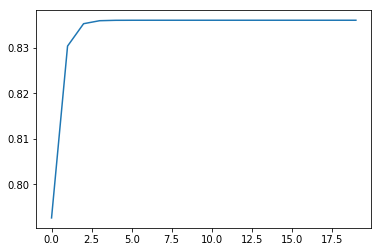

In [10]:
import numpy as np
from scipy.special import binom
import matplotlib.pyplot as plt

def p(r,N,g,e):
    if g==0:
        return binom(N,r)*(e)**r*(1-e)**(N-r)
    if g==1:
        return binom(N,r)*2**(-N)
    if g==2:
        return binom(N,r)*(1-e)**r*e**(N-r)

def L(r,N,g,e,psi):
    '''
    r - observed number of reference alleles in the sample
    N - depth
    g - genotype
    e - error rate (asumed the same for all reads)
    psi - reference allele frequency
    
    Returns: P((r,N)|g, \psi)
    '''
    return p(r,N,g,e)*binom(2,g)*(psi**g*(1-psi)**(2-g))

def mpsinew1(r,N,e,psi):
    '''
    r - observed number of reference alleles
    N - depth
    e - error rate
    psi - reference allele frequency
    
    Returns: Expected genotype E(g|d,psi)
    '''
    return np.sum([g*L(r,N,g,e,psi) for g in [0,1,2]])/np.sum([L(r,N,g,e,psi) for g in [0,1,2]])


def EM(N,e,psi0,D,iters):
    '''
    N - depth
    e - error rate
    psi0 - initial guess for allele frequency in the population
    D - the data (a list of integers between 0 and N)
    iters - the number of iterations
    
    Returns: list of iters new estimates for psi
    '''
    psi=psi0
    ans = []
    for i in range(iters):
        S=[mpsinew1(r,N,e,psi) for r in D]
        psi=np.sum(S)/2/len(D)
        ans.append(psi)
    return ans
        
N=20
e=.1
psi0=.5
D=[15,18,13,12,17,15,8,16,19,16]
L=EM(N,e,psi0,D,20)
plt.plot(range(len(L)),L)

## Bayesian perspective

From a Bayesian point of view, we have a hierarchical model where we can pick:
- a uniform prior on $\psi$ (for example) 
- the genotype is distributed as $\mathrm{binomial}(2,\psi)$
- given the genotype, and assuming constant depth $N$ and constant error rate $\epsilon$, the number $r$ of reference alleles is distributed as 
    - $\mathrm{binomial}(N,1-\epsilon)$ if $g=2$
    - $\mathrm{binomial}(N,1/2)$ if $g=1$
    - $\mathrm{binomial}(N,\epsilon)$ if $g=0$.

